# NIFTY Data Analysis Workflow

This notebook demonstrates a comprehensive workflow for:
1. Fetching NIFTY data for 2025 using Kite Connect API
2. Saving the data as CSV
3. Analyzing candlestick patterns
4. Generating comprehensive reports

The workflow uses Pydantic for data validation and orchestration.

In [10]:
# Import required libraries
import sys
import os
import pandas as pd
from datetime import datetime, timedelta
from typing import Optional, Dict, Any, List
import logging
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Fix the import path - add the correct path to src directory
current_dir = os.path.dirname('.')
src_path = os.path.join(current_dir, '..')
sys.path.insert(0, src_path)

# Now import the modules
from data_fetcher import KiteConnectDataFetcher
from candlestick_patterns import CandlestickPatternAnalyzer
from pydantic import BaseModel, Field

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("✅ Libraries imported successfully")
print(f"�� Current directory: {os.getcwd()}")
print(f"📁 Added to path: {src_path}")

✅ Libraries imported successfully
�� Current directory: c:\Users\Sandeep\Documents\Work\code\candle-pattern-test\src\workflow
📁 Added to path: ..


## Step 1: Initialize Components

In [11]:
# Initialize workflow components with correct config path
config_path = os.path.join(os.path.dirname('.'), '..', '..', 'config', 'local-settings.json')
data_fetcher = KiteConnectDataFetcher(config_path)
pattern_analyzer = CandlestickPatternAnalyzer()

# Ensure data directory exists
data_dir = Path("../../data")
data_dir.mkdir(exist_ok=True)

print("✅ Components initialized successfully")
print(f"📁 Data directory: {data_dir.absolute()}")
print(f"📁 Config path: {config_path}")

2025-10-31 18:47:36,527 INFO data_fetcher Initializing KiteConnectDataFetcher with config: ..\..\config\local-settings.json
2025-10-31 18:47:36,531 INFO auth.token_manager Initializing TokenManager with config: ..\..\config\local-settings.json
2025-10-31 18:47:36,536 INFO auth.token_manager TokenManager initialized successfully
2025-10-31 18:47:36,539 INFO data_fetcher Data fetcher initialized with NIFTY token: 256265


✅ Components initialized successfully
📁 Data directory: c:\Users\Sandeep\Documents\Work\code\candle-pattern-test\src\workflow\..\..\data
📁 Config path: ..\..\config\local-settings.json


## Step 2: Fetch NIFTY Data for 2024 and 2025

In [12]:
# Define date range for 2025
from_date = "2024-01-01"
to_date = "2025-12-31"

print(f"📊 Fetching NIFTY data from {from_date} to {to_date}")

# Fetch historical data
df = data_fetcher.get_historical_data(
    from_date=from_date,
    to_date=to_date,
    interval='day'
)

if df.empty:
    print("⚠️  No data fetched for the specified date range")
else:
    print(f"✅ Successfully fetched {len(df)} daily candles")
    print(f"📅 Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"💰 Price range: {df['low'].min():.2f} - {df['high'].max():.2f}")
    
    # Display first few rows
    display(df.head())

2025-10-31 18:47:36,574 INFO data_fetcher Fetching historical data for NIFTY from 2024-01-01 to 2025-12-31 with interval: day
2025-10-31 18:47:36,578 INFO auth.token_manager Getting valid Kite Connect instance
2025-10-31 18:47:36,583 INFO auth.token_manager No previous token check found - token needs validation
2025-10-31 18:47:36,585 INFO auth.token_manager Token needs refresh or validation - attempting refresh
2025-10-31 18:47:36,587 INFO auth.token_manager Attempting automatic token refresh
2025-10-31 18:47:36,590 WARNING auth.token_manager API key or refresh token not found for automatic refresh
2025-10-31 18:47:36,596 WARNING auth.token_manager Automatic token refresh failed - using current token
2025-10-31 18:47:36,597 INFO auth.token_manager Kite Connect instance ready with valid token
2025-10-31 18:47:36,601 INFO data_fetcher Making API call to fetch day candles for NIFTY


📊 Fetching NIFTY data from 2024-01-01 to 2025-12-31


2025-10-31 18:47:38,212 INFO data_fetcher Successfully fetched 457 candles for NIFTY from 2024-01-01 to 2025-12-31


✅ Successfully fetched 457 daily candles
📅 Date range: 2024-01-01 00:00:00+05:30 to 2025-10-31 00:00:00+05:30
💰 Price range: 21137.20 - 26277.35


,date,open,high,low,close,volume
0,2024-01-01 00:00:00+05:30,21727.75,21834.35,21680.85,21741.90,0
1,2024-01-02 00:00:00+05:30,21751.35,21755.60,21555.65,21665.80,0
2,2024-01-03 00:00:00+05:30,21661.10,21677.00,21500.35,21517.35,0
3,2024-01-04 00:00:00+05:30,21605.80,21685.65,21564.55,21658.60,0
4,2024-01-05 00:00:00+05:30,21705.75,21749.60,21629.20,21710.80,0


## Step 3: Save Data as CSV

In [13]:
# Save to CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_filename = f"nifty_daily_2025_{timestamp}.csv"
csv_path = data_dir / csv_filename

# Ensure column names are correct
if 'date' in df.columns:
    df = df.rename(columns={
        'date': 'Date',
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'volume': 'Volume'
    })

df.to_csv(csv_path, index=False)
print(f"💾 Data saved to: {csv_path}")
print(f"📁 File size: {csv_path.stat().st_size / 1024:.1f} KB")

💾 Data saved to: ..\..\data\nifty_daily_2025_20251031_184738.csv
📁 File size: 28.1 KB


## Step 4: Analyze Candlestick Patterns

In [14]:
# Analyze patterns
print("🔍 Analyzing candlestick patterns...")
df_with_patterns = pattern_analyzer.analyze_patterns(df)

# Get pattern summary
pattern_summary = pattern_analyzer.get_pattern_summary(df_with_patterns)

print(f"✅ Pattern analysis completed for {len(df_with_patterns)} candles")
print("\n📊 Pattern Summary:")
for pattern, count in pattern_summary.items():
    if count > 0:
        print(f"  - {pattern}: {count} occurrences")

# Display rows with patterns
pattern_rows = df_with_patterns[df_with_patterns['pattern'] != '']
if not pattern_rows.empty:
    print(f"\n🎯 Found {len(pattern_rows)} candles with patterns:")
    display(pattern_rows[['Date', 'Open', 'High', 'Low', 'Close', 'pattern']].head(10))

🔍 Analyzing candlestick patterns...


2025-10-31 18:47:38,897 INFO candlestick_patterns Pattern analysis completed for 457 candles


✅ Pattern analysis completed for 457 candles

📊 Pattern Summary:
  - hammer: 33 occurrences
  - shooting_star: 26 occurrences
  - bullish_engulfing: 11 occurrences
  - bearish_engulfing: 26 occurrences

🎯 Found 95 candles with patterns:


,Date,Open,High,Low,Close,pattern
0,2024-01-01 00:00:00+05:30,21727.75,21834.35,21680.85,21741.90,shooting_star
1,2024-01-02 00:00:00+05:30,21751.35,21755.60,21555.65,21665.80,bearish_engulfing
4,2024-01-05 00:00:00+05:30,21705.75,21749.60,21629.20,21710.80,hammer
5,2024-01-08 00:00:00+05:30,21747.60,21763.95,21492.90,21513.00,bearish_engulfing
12,2024-01-17 00:00:00+05:30,21647.25,21851.50,21550.45,21571.95,shooting_star
15,2024-01-20 00:00:00+05:30,21706.15,21720.30,21541.80,21571.80,bearish_engulfing
23,2024-02-02 00:00:00+05:30,21812.75,22126.80,21805.55,21853.80,shooting_star
24,2024-02-05 00:00:00+05:30,21921.05,21964.30,21726.95,21771.70,bearish_engulfing
29,2024-02-12 00:00:00+05:30,21800.80,21831.70,21574.75,21616.05,bearish_engulfing
32,2024-02-15 00:00:00+05:30,21906.55,21953.85,21794.80,21910.75,hammer


## Step 5: Generate Pattern Analysis Report

In [15]:
# Get pattern dates for each pattern type
pattern_dates = {}
for pattern_name in pattern_summary.keys():
    dates = pattern_analyzer.get_pattern_dates(df_with_patterns, pattern_name)
    pattern_dates[pattern_name] = dates

# Create timestamp if not already defined
if 'timestamp' not in locals():
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save results
output_filename = f"nifty_pattern_analysis_{timestamp}.csv"
output_path = data_dir / output_filename
df_with_patterns.to_csv(output_path, index=False)

print(f"💾 Pattern analysis results saved to: {output_path}")

# Generate comprehensive summary
total_patterns = sum(pattern_summary.values())
total_candles = len(df_with_patterns)
pattern_percentage = (total_patterns / total_candles * 100) if total_candles > 0 else 0

print("\n" + "="*60)
print("NIFTY CANDLESTICK PATTERN ANALYSIS SUMMARY")
print("="*60)
print(f"Total candles analyzed: {total_candles}")
print(f"Total patterns found: {total_patterns}")
print(f"Pattern occurrence rate: {pattern_percentage:.2f}%")
print("\nPattern Breakdown:")

for pattern, count in pattern_summary.items():
    if count > 0:
        print(f"- {pattern}: {count} occurrences")
        if pattern in pattern_dates and pattern_dates[pattern]:
            # Convert dates to strings safely
            date_strings = [str(date) for date in pattern_dates[pattern][:5]]
            print(f"  Dates: {', '.join(date_strings)}")
            if len(pattern_dates[pattern]) > 5:
                print(f"  ... and {len(pattern_dates[pattern]) - 5} more")

# Price movement analysis - check column names
if not df.empty:
    # Use the correct column name (either 'Close' or 'close')
    close_col = 'Close' if 'Close' in df.columns else 'close'
    high_col = 'High' if 'High' in df.columns else 'high'
    low_col = 'Low' if 'Low' in df.columns else 'low'
    
    price_change = df[close_col].iloc[-1] - df[close_col].iloc[0]
    price_change_pct = (price_change / df[close_col].iloc[0]) * 100
    print(f"\nPrice Movement Analysis:")
    print(f"- Start price: {df[close_col].iloc[0]:.2f}")
    print(f"- End price: {df[close_col].iloc[-1]:.2f}")
    print(f"- Total change: {price_change:.2f} ({price_change_pct:+.2f}%)")
    print(f"- Highest price: {df[high_col].max():.2f}")
    print(f"- Lowest price: {df[low_col].min():.2f}")

print("="*60)

💾 Pattern analysis results saved to: ..\..\data\nifty_pattern_analysis_20251031_184738.csv

NIFTY CANDLESTICK PATTERN ANALYSIS SUMMARY
Total candles analyzed: 457
Total patterns found: 96
Pattern occurrence rate: 21.01%

Pattern Breakdown:
- hammer: 33 occurrences
  Dates: 2024-01-05 00:00:00+05:30, 2024-02-15 00:00:00+05:30, 2024-03-07 00:00:00+05:30, 2024-04-04 00:00:00+05:30, 2024-04-22 00:00:00+05:30
  ... and 28 more
- shooting_star: 26 occurrences
  Dates: 2024-01-01 00:00:00+05:30, 2024-01-17 00:00:00+05:30, 2024-02-02 00:00:00+05:30, 2024-04-01 00:00:00+05:30, 2024-06-12 00:00:00+05:30
  ... and 21 more
- bullish_engulfing: 11 occurrences
  Dates: 2024-02-27 00:00:00+05:30, 2024-03-06 00:00:00+05:30, 2024-04-25 00:00:00+05:30, 2024-05-21 00:00:00+05:30, 2024-07-01 00:00:00+05:30
  ... and 6 more
- bearish_engulfing: 26 occurrences
  Dates: 2024-01-02 00:00:00+05:30, 2024-01-08 00:00:00+05:30, 2024-01-20 00:00:00+05:30, 2024-02-05 00:00:00+05:30, 2024-02-12 00:00:00+05:30
  ... 

## Step 6: Visualize Results

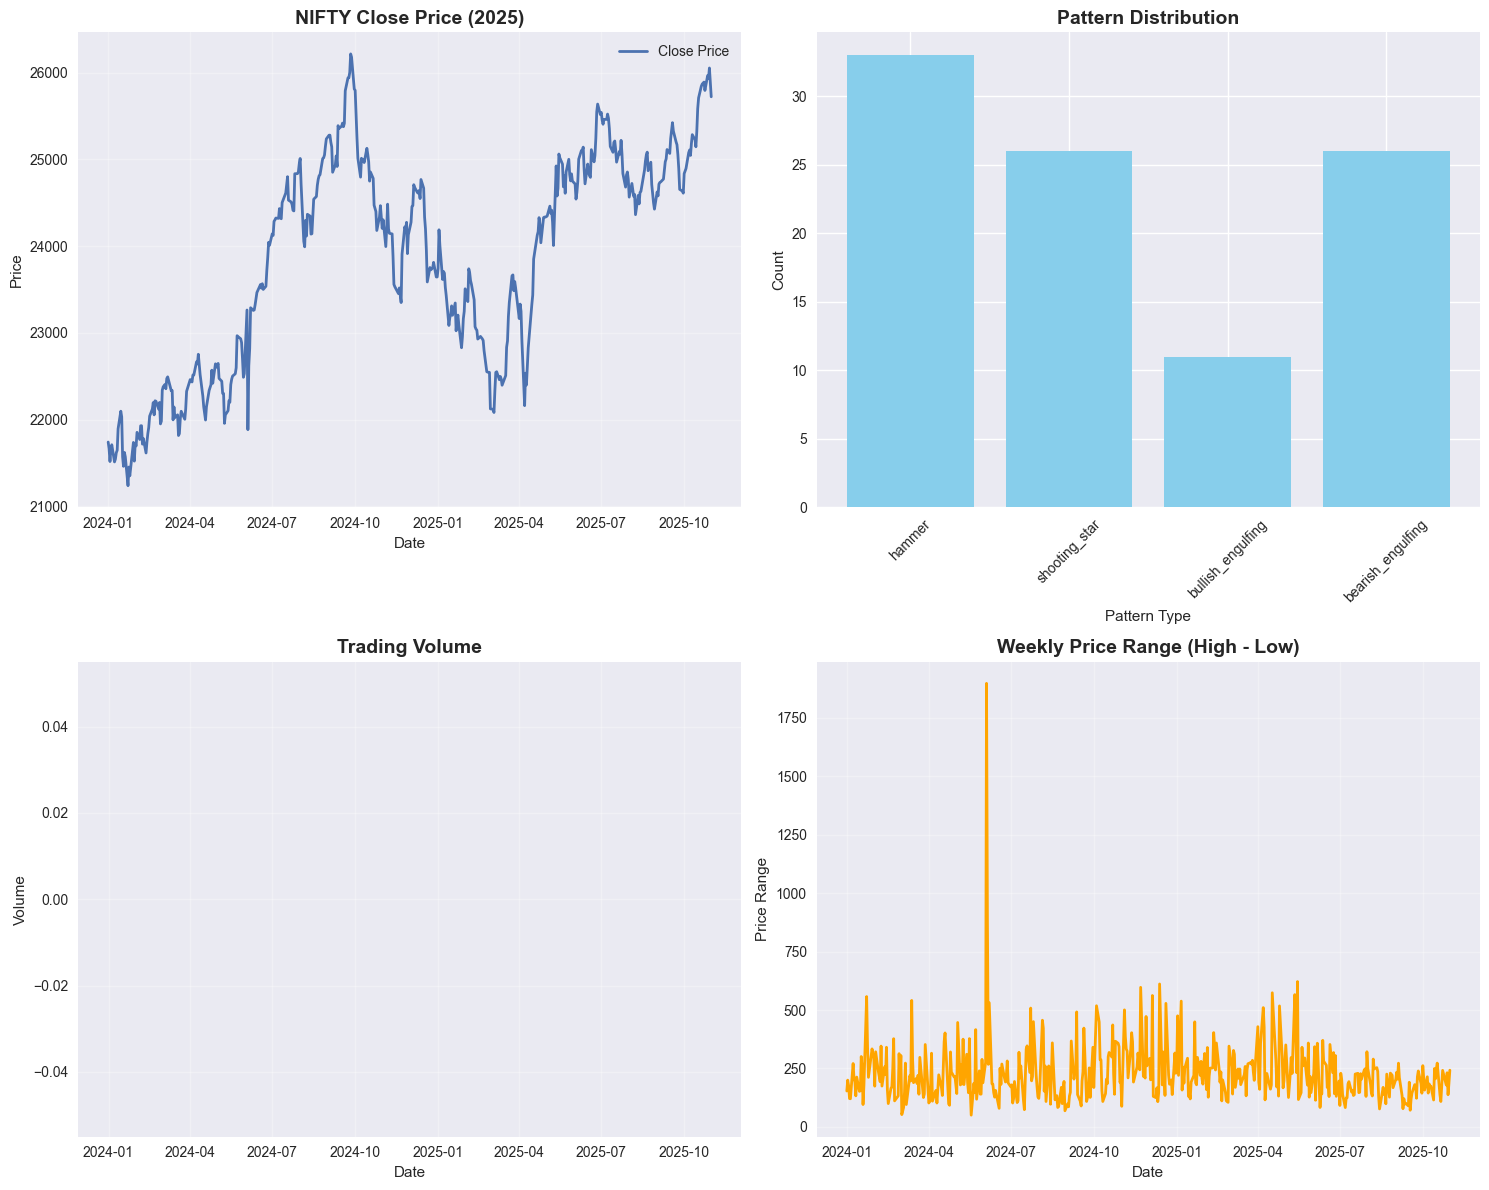

📊 Visualizations generated successfully!


In [16]:
# Create visualizations
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Price chart with patterns
ax1 = axes[0, 0]
ax1.plot(df['Date'], df['Close'], label='Close Price', linewidth=2)
ax1.set_title('NIFTY Close Price (2025)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Pattern distribution
ax2 = axes[0, 1]
patterns_with_counts = {k: v for k, v in pattern_summary.items() if v > 0}
if patterns_with_counts:
    ax2.bar(patterns_with_counts.keys(), patterns_with_counts.values(), color='skyblue')
    ax2.set_title('Pattern Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Pattern Type')
    ax2.set_ylabel('Count')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# 3. Volume analysis
ax3 = axes[1, 0]
ax3.bar(df['Date'], df['Volume'], alpha=0.7, color='lightgreen')
ax3.set_title('Trading Volume', fontsize=14, fontweight='bold')
ax3.set_xlabel('Date')
ax3.set_ylabel('Volume')
ax3.grid(True, alpha=0.3)

# 4. Price range (High-Low)
ax4 = axes[1, 1]
price_range = df['High'] - df['Low']
ax4.plot(df['Date'], price_range, color='orange', linewidth=2)
ax4.set_title('Weekly Price Range (High - Low)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Date')
ax4.set_ylabel('Price Range')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Visualizations generated successfully!")

## Step 7: Summary and Next Steps

In [17]:
print("🎉 NIFTY Data Analysis Workflow Completed Successfully!")
print("\n📁 Generated Files:")
print(f"  - Raw data: {csv_path}")
print(f"  - Pattern analysis: {output_path}")
print("\n📊 Key Insights:")
print(f"  - Analyzed {len(df)} daily candles")
print(f"  - Found {sum(pattern_summary.values())} candlestick patterns")
print(f"  - Pattern occurrence rate: {(sum(pattern_summary.values()) / len(df) * 100):.2f}%")

print("\n🚀 Next Steps:")
print("  - Review specific pattern dates for trading signals")
print("  - Analyze pattern effectiveness in different market conditions")
print("  - Extend analysis to other timeframes (hourly, weekly)")
print("  - Integrate with additional technical indicators")

🎉 NIFTY Data Analysis Workflow Completed Successfully!

📁 Generated Files:
  - Raw data: ..\..\data\nifty_daily_2025_20251031_184738.csv
  - Pattern analysis: ..\..\data\nifty_pattern_analysis_20251031_184738.csv

📊 Key Insights:
  - Analyzed 457 daily candles
  - Found 96 candlestick patterns
  - Pattern occurrence rate: 21.01%

🚀 Next Steps:
  - Review specific pattern dates for trading signals
  - Analyze pattern effectiveness in different market conditions
  - Extend analysis to other timeframes (hourly, weekly)
  - Integrate with additional technical indicators
